In [31]:
import requests
import sys
import os
import uuid
from datetime import datetime
import json
import ast
import time
import re

import dotenv
import seaborn as sns
import matplotlib.pyplot as plt
from flask import Response
import pandas as pd
import numpy as np
from tqdm import tqdm
from trulens_eval import Tru, Feedback, Select, TruCustomApp, Provider
from trulens_eval.feedback import Groundedness, GroundTruthAgreement
from trulens_eval.feedback.provider.openai import AzureOpenAI as fAzureOpenAI
from trulens_eval.tru_custom_app import instrument
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient  
from azure.search.documents.models import (
    QueryType,
    VectorizedQuery,
)
from openai import AzureOpenAI

from config import settings

tru = Tru()

pd.options.mode.chained_assignment = None



In [42]:
# CHOOSE APP VERSION TO TEST
versions = [
    "prod-3",
]

eval_set_file = "FEMA_eval_set.xlsx"

In [43]:
# SET ALL CONFIGURATIONS AUTOMATICALLY 

def set_version_configurations(version):
    env_file = dotenv.find_dotenv()
    dotenv.load_dotenv(env_file)
    dotenv.set_key(env_file, "VERSION_ID", version)

    settings.VERSION_ID = version
    settings.AZURE_OPENAI_STREAM = False
    settings.get_version_configs()

    # Overwrite system settings with experiment-specific configs
    settings.AZURE_OPENAI_MODEL = "dep-gpt-35-16k"
    os.environ["AZURE_OPENAI_API_KEY"] = settings.AZURE_OPENAI_KEY

    with open("config.json", "w") as f:
        json.dump([settings.PREP_CONFIG], f)

set_version_configurations(versions[0])

RETRIES = 2

pricing = {
    "gpt-4-32k": {
        "prompt": 0.06,
        "completion": 0.12
    },
    "gpt-3.5-turbo-16k": {
        "prompt": 0.003,
        "completion": 0.004
    }
}

azcs_search_client = SearchClient(
    endpoint=f"https://{settings.AZURE_SEARCH_SERVICE}.search.windows.net", 
    index_name=settings.AZURE_SEARCH_INDEX, 
    credential=AzureKeyCredential(settings.AZURE_SEARCH_KEY))

aoai_client = AzureOpenAI(
    api_key=settings.AZURE_OPENAI_KEY,
    api_version=settings.AZURE_OPENAI_PREVIEW_API_VERSION,
    azure_endpoint=settings.AZURE_OPENAI_ENDPOINT
)

In [4]:
if settings.PREP_CONFIG:
    embedding_model_endpoint = settings.AZURE_OPENAI_EMBEDDING_ENDPOINT

    # Run Data Preproc Script WITH Document Intelligence
    if settings.PREP_CONFIG.get("form_rec_resource", None) and settings.PREP_CONFIG.get("form_rec_key", None):
        form_rec_resource = settings.PREP_CONFIG["form_rec_resource"]
        form_rec_key = settings.PREP_CONFIG["form_rec_key"]
        
        print(f"Run the following command in terminal:\naz login --tenant 031d8bee-cd40-4791-b63c-bc890be44c22\npython data_preparation.py --njobs=1 --form-rec-resource={form_rec_resource} --form-rec-key={form_rec_key} --form-rec-use-layout --embedding-model-endpoint={embedding_model_endpoint}")
    
    # Run Data Preproc Script WITHOUT Document Intelligence
    else:
        print(f"""Run the following commands in terminal:\naz login --tenant 031d8bee-cd40-4791-b63c-bc890be44c22\npython data_preparation.py --njobs=1 --embedding-model-endpoint={embedding_model_endpoint}""")

## Prompts

In [44]:
MAKE_QUERY_PROMPTS = {
"prod-1": """
Create a search engine query that retrieves documents similar to the following user query: {query}

Format your response as a JSON object following this template: {{"search_query": "natural language search query for search engine", "keywords": "keyword1, keyword2, etc."}}

Your search query:
""",
"prod-2": """
Create a search engine query that retrieves documents similar to the following user query: {query}

Format your response as a JSON object following this template: {{"search_query": "natural language search query for search engine", "keywords": "keyword1, keyword2, etc."}}

Your search query:
""",
"prod-3": """
Create a semantic search engine query and set of keywords that retrieves documents similar to the following QUERY:

================================
QUERY: {query}
================================

Align your search query and keywords with the intent of the original QUERY, and simplify the query where needed. Format your response as a JSON object following this template: {{"search_query": "natural language search query for semantic search engine", "keywords": "keyword1, keyword2, etc."}}

Your search query:
"""
}

RETRY_MAKE_QUERY_PROMPT = """
ATTEMPT {attempt}:
Your last attempt to produce a formatted search query failed. Make sure you format the supplied QUERY according to the following template: {{"search_query": "natural language search query for semantic search engine", "keywords": "keyword1, keyword2, etc."}}

Your search query:
"""

RAG_PROMPTS = {
"prod-1": """
REFERENCES are provided below as a knowledge source. 

================================
REFERENCES: 
{references}
================================

Respond to the user QUERY below using the supplied REFERENCES. 

================================
QUERY: 
{query}
================================

Keep your response objective and factual and use an informational report-style tone. Do not include content outside of the supplied REFERENCES. Cite ANY and ALL sentences that come from text in the REFERENCES using "[docN]" notation. For example, if a given sentence uses the first document in CITATIONS, add "[doc1]" to the end of that sentence. Likewise, use "[doc2]" if citing the second document in CITATIONS. DO NOT use any citation convention other than "[docN]".

Your response:
""",
"prod-2": """
REFERENCES are provided below as a knowledge source. 

================================
REFERENCES: 
{references}
================================

Respond to the user QUERY below using the supplied REFERENCES. 

================================
QUERY: 
{query}
================================

Keep your response objective and factual and use an informational report-style tone. Do not include content outside of the supplied REFERENCES. Cite ANY and ALL sentences that come from text in the REFERENCES using "[docN]" notation. For example, if a given sentence uses the first document in CITATIONS, add "[doc1]" to the end of that sentence. Likewise, use "[doc2]" if citing the second document in CITATIONS. DO NOT use any citation convention other than "[docN]".

Your response:
""",
"prod-3": """
REFERENCES are provided below as a knowledge source. 

================================
REFERENCES: 
{references}
================================

Respond to the user QUERY below using the supplied REFERENCES. 

================================
QUERY: 
{query}
================================

Keep your response objective and factual and use an informational report-style tone. Do not include content outside of the supplied REFERENCES. Cite ANY and ALL sentences that come from text in the REFERENCES using "[docN]" notation. For example, if a given sentence uses the first document in CITATIONS, add "[doc1]" to the end of that sentence. Likewise, use "[doc2]" if citing the second document in CITATIONS. DO NOT use any citation convention other than "[docN]".

Your response:
"""}

## Helper Functions

In [29]:
def format_as_ndjson(obj: dict) -> str:
    return json.dumps(obj, ensure_ascii=False) + "\n"

def get_filter(messages: list[dict[str, str]]):
    filter_map = {
        "c": "congressional_budget_justification", 
        "q": "qfr", 
        "s": "supplemental"
    }
    
    user_msg_segmented = messages[-1]["content"].split("***")
    if len(user_msg_segmented) > 1:
        filter_list = [f.strip() for f in user_msg_segmented.pop(1).split(",")]
        filter_list = [f"doc_type eq '{filter_map[f]}'" for f in filter_list if f in filter_map.keys()]

        if filter_list:
            filter = " or ".join(filter_list)
        else:
            filter = None
        
        messages[-1]["content"] = "".join(user_msg_segmented)

    else:
        filter = None
    
    return filter, messages

def prepare_body_headers_with_data(request):
    request_messages = request["messages"]

    # Set query type
    query_type = "simple"
    if settings.AZURE_SEARCH_QUERY_TYPE:
        query_type = settings.AZURE_SEARCH_QUERY_TYPE
    elif settings.AZURE_SEARCH_USE_SEMANTIC_SEARCH.lower() == "true" and settings.AZURE_SEARCH_SEMANTIC_SEARCH_CONFIG:
        query_type = "semantic"

    # Set filter
    filter, request_messages = get_filter(request_messages)
    
    if settings.AZURE_SEARCH_DOC_TYPES:
        filter_list = []
        doc_types_list = settings.AZURE_SEARCH_DOC_TYPES.split(", ")
        for doc_type in doc_types_list:
            filter_list.append(f"doc_type eq '{doc_type}'")
        filter = " or ".join(filter_list)

    body = {
        "messages": request_messages,
        "temperature": float(settings.AZURE_OPENAI_TEMPERATURE),
        "max_tokens": int(settings.AZURE_OPENAI_MAX_TOKENS),
        "top_p": float(settings.AZURE_OPENAI_TOP_P),
        "stop": settings.AZURE_OPENAI_STOP_SEQUENCE.split("|") if settings.AZURE_OPENAI_STOP_SEQUENCE else None,
        "stream": settings.AZURE_OPENAI_STREAM,
        "dataSources": [
            {
                "type": "AzureCognitiveSearch",
                "parameters": {
                    "endpoint": f"https://{settings.AZURE_SEARCH_SERVICE}.search.windows.net",
                    "key": settings.AZURE_SEARCH_KEY,
                    "indexName": settings.AZURE_SEARCH_INDEX,
                    "fieldsMapping": {
                        "contentFields": settings.AZURE_SEARCH_CONTENT_COLUMNS.split("|") if settings.AZURE_SEARCH_CONTENT_COLUMNS else [],
                        "titleField": settings.AZURE_SEARCH_TITLE_COLUMN if settings.AZURE_SEARCH_TITLE_COLUMN else None,
                        "urlField": settings.AZURE_SEARCH_URL_COLUMN if settings.AZURE_SEARCH_URL_COLUMN else None,
                        "filepathField": settings.AZURE_SEARCH_FILENAME_COLUMN if settings.AZURE_SEARCH_FILENAME_COLUMN else None,
                        "vectorFields": settings.AZURE_SEARCH_VECTOR_COLUMNS.split("|") if settings.AZURE_SEARCH_VECTOR_COLUMNS else []
                    },
                    "inScope": True if settings.AZURE_SEARCH_ENABLE_IN_DOMAIN.lower() == "true" else False,
                    "topNDocuments": settings.AZURE_SEARCH_TOP_K,
                    "queryType": query_type,
                    "semanticConfiguration": settings.AZURE_SEARCH_SEMANTIC_SEARCH_CONFIG if settings.AZURE_SEARCH_SEMANTIC_SEARCH_CONFIG else "",
                    "roleInformation": settings.AZURE_OPENAI_SYSTEM_MESSAGE,
                    "embeddingEndpoint": settings.AZURE_OPENAI_EMBEDDING_ENDPOINT,
                    "embeddingKey": settings.AZURE_OPENAI_EMBEDDING_KEY,
                    "filter": filter
                }
            }
        ]
    }

    headers = {
        'Content-Type': 'application/json',
        'api-key': settings.AZURE_OPENAI_KEY,
        "x-ms-useragent": "GitHubSampleWebApp/PublicAPI/2.0.0"
    }

    return body, headers
    

def conversation_with_data2(request):
    body, headers = prepare_body_headers_with_data(request)
    base_url = settings.AZURE_OPENAI_ENDPOINT if settings.AZURE_OPENAI_ENDPOINT else f"https://{settings.AZURE_OPENAI_RESOURCE}.openai.azure.com/"
    endpoint = f"{base_url}openai/deployments/{settings.AZURE_OPENAI_MODEL}/extensions/chat/completions?api-version={settings.AZURE_OPENAI_PREVIEW_API_VERSION}"
    history_metadata = request.get("history_metadata", {})

    if not settings.AZURE_OPENAI_STREAM:
        r = requests.post(endpoint, headers=headers, json=body)
        status_code = r.status_code
        r = r.json()
        r['history_metadata'] = history_metadata

        return r
    else:
        return Response(stream_with_data(body, headers, endpoint, history_metadata), mimetype='text/event-stream')


def create_prompt(question, q_type):
    prompt_mods = {
            "Number": " Provide just the number in your response, fully written out. For example, if the number is '300 million' or '3,000 (in thousands)' return your number as 300000000. If providing a negative number, report it with a minus sign, e.g. '-300'.",
            "Keyword": " Report your answer(s) using the exact wording from the retrieved documents."
        }

    prompt_mod = prompt_mods.get(q_type, "")

    return question + prompt_mod


def aoai_answer(prompt):
    for _ in range(RETRIES):
        request = {
            "messages": [
                {
                    "id": str(uuid.uuid4()),
                    "role": "user",
                    "content": prompt,
                    "end_turn": True,
                    "date": datetime.today().strftime('%Y-%m-%d')
                }
            ]
        }

        response = conversation_with_data2(request)
        try:
            answer = response["choices"][0]["messages"][1]["content"]
            citation_json = ast.literal_eval(response["choices"][0]["messages"][0]["content"].replace("null", '""'))["citations"]
            return response
        except:
            print("Request failed likely due to rate limit. Waiting 1 min and retrying...")
            print(response)
            time.sleep(60)
    
    return response

def prepare_body_headers(request_messages):

    body = {
        "messages": request_messages,
        "temperature": float(settings.AZURE_OPENAI_TEMPERATURE),
        "max_tokens": int(settings.AZURE_OPENAI_MAX_TOKENS),
        "top_p": float(settings.AZURE_OPENAI_TOP_P),
        "stop": settings.AZURE_OPENAI_STOP_SEQUENCE.split("|") if settings.AZURE_OPENAI_STOP_SEQUENCE else None,
        "stream": settings.AZURE_OPENAI_STREAM,
    }

    headers = {
        'Content-Type': 'application/json',
        'api-key': settings.AZURE_OPENAI_KEY,
    }

    return body, headers

def static_response(body, headers, endpoint, sources, intent, history_metadata={}):
    r = requests.post(endpoint, headers=headers, json=body)
    status_code = r.status_code
    full_response = r.json()
    full_response["choices"] = [
        {
            "index": 0,
            "messages": [
                {
                    "index": 0, 
                    "role": "tool",
                    "content": format_as_ndjson({"citations": sources, "intent": intent}),
                    "end_turn": False
                },
                {
                    "index": 1,
                    "role": "assistant",
                    "content": full_response["choices"][0]["message"]["content"],
                    "end_turn": True
                }
            ]
        }
    ]
    full_response['history_metadata'] = history_metadata

    return full_response, status_code

def get_embedding(text):
    try:
        embedding_client = AzureOpenAI(
            api_key = settings.AZURE_OPENAI_KEY,
            api_version = settings.AZURE_OPENAI_PREVIEW_API_VERSION,
            azure_endpoint = settings.AZURE_OPENAI_EMBEDDING_ENDPOINT
        )

        response = embedding_client.embeddings.create(
            input=text,
            model="text-embedding-ada-002"
        )
        
        embeddings = ast.literal_eval(response.json())["data"][0]["embedding"]
        
        return embeddings

    except Exception as e:
        raise Exception(f"Error getting embeddings with endpoint={settings.AZURE_OPENAI_EMBEDDING_ENDPOINT} with error={e}")

def search_knowledgebase(search_query, key_words, filter):

    vector = VectorizedQuery(vector=get_embedding(search_query), fields="contentVector")

    ###### If / else logic unique to experiment engine ######
    if settings.AZURE_SEARCH_USE_SEMANTIC_SEARCH == True:
        results = azcs_search_client.search(
            search_text=key_words,
            vector_queries=[vector],
            query_type="semantic",
            semantic_configuration_name="default",
            top=10
        )
    else:
        results = azcs_search_client.search(
            search_text=key_words,
            vector_queries=[vector],
            top=10
        )
    #########################################################

    source_list = []
    for source in results:
        source_dict = {key: source[key] for key in ["content", "id", "title", "filepath", "url", "metadata"]}
        source_dict["metadata"] = ast.literal_eval(source_dict["metadata"])
        source_dict["chunk_id"] = source_dict["metadata"]["chunk_idx"]
        source_list.append(source_dict)
    
    text_content =""
    for i, result in enumerate(source_list):
        text_content += f"{i+1}. {result['content']}\n\n"
        
    return text_content, source_list


def compose_basic_query_params(query):
    stop_words = [
        "a", "an", "the",
        "in", "on", "at", "of", "to", "with", "by", "for",
        "and", "but", "or", "so", "if", "because",
        "I", "you", "he", "she", "it", "we", "they",
        "is", "am", "are", "was", "were", "be", "been",
        "have", "has", "had", "do", "does", "did"
    ]
    keywords_basic = []
    words = [word for word in query.split() if word.lower() not in stop_words]
    for i in range(0, len(words) - 1, 2):
        if i +1 < len(words):
            keywords_basic.append(f"{words[i]} {words[i+1]}")
        else:
            keywords_basic.append(words[i])
    
    return {"search_query": query, "keywords": keywords_basic}


def compose_query_params(request_messages):
    query = request_messages[-1]["content"]
    request_messages.append({"role": "user", "content": MAKE_QUERY_PROMPTS[settings.VERSION_ID].format(query=query)})
    retries = 3

    for i in range(retries):
        try:
            query_param_response = aoai_client.chat.completions.create(
                model=settings.AZURE_OPENAI_MODEL,
                messages=request_messages
            )
            query_params = ast.literal_eval(query_param_response.choices[0].message.content)
            assert "search_query" in query_params.keys() and "keywords" in query_params.keys()
            assert type(query_params["search_query"]) == str and type(query_params["keywords"]) == str
            return request_messages, query_params
        
        except:
            request_messages[-1]["content"] = request_messages[-1]["content"] + RETRY_MAKE_QUERY_PROMPT.format(attempt=i)
    
    # If GenAI formatting fails, use fallback option
    return request_messages, compose_basic_query_params(query)


def get_cost(response, model_name):
    return (response["usage"]["prompt_tokens"]/1000)*pricing[model_name]["prompt"] + (response["usage"]["completion_tokens"]/1000)*pricing[model_name]["completion"]


def number_check(answer, gen_text):
    text_numbers = re.findall(r'\d+', gen_text)
    return 1 if str(answer) in text_numbers else 0


def text2int (textnum, numwords={}):
    if not numwords:
        units = [
        "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
        "sixteen", "seventeen", "eighteen", "nineteen",
        ]

        tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]

        scales = ["hundred", "thousand", "million", "billion", "trillion"]

        numwords["and"] = (1, 0)
        for idx, word in enumerate(units):  numwords[word] = (1, idx)
        for idx, word in enumerate(tens):       numwords[word] = (1, idx * 10)
        for idx, word in enumerate(scales): numwords[word] = (10 ** (idx * 3 or 2), 0)

    ordinal_words = {'first':1, 'second':2, 'third':3, 'fifth':5, 'eighth':8, 'ninth':9, 'twelfth':12}
    ordinal_endings = [('ieth', 'y'), ('th', '')]

    textnum = textnum.replace('-', ' ')

    current = result = 0
    curstring = ""
    onnumber = False
    for word in textnum.split():
        if word in ordinal_words:
            scale, increment = (1, ordinal_words[word])
            current = current * scale + increment
            if scale > 100:
                result += current
                current = 0
            onnumber = True
        else:
            for ending, replacement in ordinal_endings:
                if word.endswith(ending):
                    word = "%s%s" % (word[:-len(ending)], replacement)

            if word not in numwords:
                if onnumber:
                    curstring += repr(result + current) + " "
                curstring += word + " "
                result = current = 0
                onnumber = False
            else:
                scale, increment = numwords[word]

                current = current * scale + increment
                if scale > 100:
                    result += current
                    current = 0
                onnumber = True

    if onnumber:
        curstring += repr(result + current)

    return curstring

## Load Ground Truth Dataset

In [24]:
eval_df = pd.read_excel(eval_set_file)
eval_df["prompt"] = eval_df.apply(lambda x: create_prompt(x["Question"], x["Type"]), axis=1)
golden_set = [{"query": str(item[0]), "response": str(item[1])} 
            for item in list(zip(eval_df["prompt"].values, eval_df["Answer"]))]

## Experiment System 1: 
#### Hybrid Trulens LLM + Rules-based (regex) Evaluation
This approach uses Trulens LLM-based Evaluations for measuring Ground Truth Accuracy, Context Relevance, and Groundedness for each test query. For test queries with numerical answers, we use a rules-based regex evaluation method instead.

In doing so, we combine the sophistication and nuance of Trulens LLM-based evaluations for long-form text answers with the precision of rules-based regex matching for numerical answers.

In [25]:
fopenai = fAzureOpenAI(
    deployment_name=settings.AZURE_OPENAI_MODEL, 
    api_version=settings.AZURE_OPENAI_PREVIEW_API_VERSION
)

grounded = Groundedness(groundedness_provider=fopenai)

# Groundedness between answer and context chunks
f_groundedness = (
    Feedback(grounded.groundedness_measure_with_cot_reasons, name = "Groundedness")
    .on(Select.RecordCalls.retrieve.rets.collect())
    .on_output()
    .aggregate(grounded.grounded_statements_aggregator)
)

# Question/statement relevance between question and each context chunk.
f_context_relevance = (
    Feedback(fopenai.qs_relevance_with_cot_reasons, name = "Context Relevance")
    .on(Select.RecordCalls.retrieve.args.query)
    .on(Select.RecordCalls.retrieve.rets.collect())
    .aggregate(np.mean)
)

# Ground Truth Checking between gold answer and generated answer
f_ground_truth = (
    Feedback(GroundTruthAgreement(golden_set, provider=fopenai).agreement_measure, name = "Ground Truth")
    .on_input_output()
)

✅ In Groundedness, input source will be set to __record__.app.retrieve.rets.collect() .
✅ In Groundedness, input statement will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Context Relevance, input question will be set to __record__.app.retrieve.args.query .
✅ In Context Relevance, input statement will be set to __record__.app.retrieve.rets.collect() .
✅ In Ground Truth, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Ground Truth, input response will be set to __record__.main_output or `Select.RecordOutput` .


In [45]:
class RAG_Pipeline2:
    @instrument
    def retrieve(self, query: str) -> list:
        self.response = aoai_answer(query)
        citation_json = ast.literal_eval(self.response["choices"][0]["messages"][0]["content"].replace("null", '""'))["citations"]
        citations = [citation["content"] for citation in citation_json]
        return citations

    @instrument
    def generate_completion(self, query: str, context_str: list) -> str:
        return self.response["choices"][0]["messages"][1]["content"]

    @instrument
    def query(self, query: str) -> str:
        context_str = self.retrieve(query)
        completion = self.generate_completion(query, context_str)
        return completion
    
class RAG_Pipeline:
    @instrument
    def retrieve(self, query: str, keywords: str) -> list:
        citation_str, sources = search_knowledgebase(
            search_query=query, 
            key_words=keywords,
            filter=filter
        )
        self.citation_str = citation_str
        self.sources = sources
        citations = [source["content"] for source in sources]
        return citations

    @instrument
    def generate_completion(self, query: str, context_str: list) -> str:
        self.request_messages[-1] = {"role": "user", "content": RAG_PROMPTS[settings.VERSION_ID].format(references=self.citation_str, query=query)}
        body, headers = prepare_body_headers(self.request_messages)
        base_url = settings.AZURE_OPENAI_ENDPOINT if settings.AZURE_OPENAI_ENDPOINT else f"https://{settings.AZURE_OPENAI_RESOURCE}.openai.azure.com/"
        endpoint = f"{base_url}openai/deployments/{settings.AZURE_OPENAI_MODEL}/chat/completions?api-version=2023-05-15"
        intent = self.query_params["keywords"].split(", ")
        full_response, status_code = static_response(body, headers, endpoint, self.sources, intent, {})
        return full_response["choices"][0]["messages"][1]["content"]

    @instrument
    def query(self, query: str) -> str:
        # Get Query
        self.request_messages = [
            {"role": "system", "content": settings.AZURE_OPENAI_SYSTEM_MESSAGE},
            {"role": "user", "content": query}
        ]
        self.request_messages, self.query_params = compose_query_params(self.request_messages)
        query_str, keywords = self.query_params["search_query"], self.query_params["keywords"]

        # Run Query
        citations = self.retrieve(query_str, keywords)

        # Get Completion
        completion = self.generate_completion(query, citations)
        return completion
        

rag_pipeline = RAG_Pipeline()

In [46]:
for version in versions:
    set_version_configurations(version)
    print(f"Testing version {settings.VERSION_ID}")

    for i in range(2):
        tru_rag = TruCustomApp(
            rag_pipeline,
            app_id = settings.VERSION_ID + f"_replicate_{i+1}",
            feedbacks = [f_groundedness, f_context_relevance, f_ground_truth]
        )

        with tru_rag as recording:
            for ex in tqdm(golden_set, desc="evaluating"):
                rag_pipeline.query(ex["query"])

Function <function RAG_Pipeline2.generate_completion at 0x7fe094590820> was not found during instrumentation walk. Make sure it is accessible by traversing app <__main__.RAG_Pipeline object at 0x7fe081b36ef0> or provide a bound method for it as TruCustomApp constructor argument `methods_to_instrument`.
Function <function RAG_Pipeline2.generate_completion at 0x7fe0847d9870> was not found during instrumentation walk. Make sure it is accessible by traversing app <__main__.RAG_Pipeline object at 0x7fe081b36ef0> or provide a bound method for it as TruCustomApp constructor argument `methods_to_instrument`.
Function <function RAG_Pipeline.query at 0x7fe0847d9090> was not found during instrumentation walk. Make sure it is accessible by traversing app <__main__.RAG_Pipeline object at 0x7fe081b36ef0> or provide a bound method for it as TruCustomApp constructor argument `methods_to_instrument`.
Function <function RAG_Pipeline2.retrieve at 0x7fe0846a49d0> was not found during instrumentation walk.

Function <function RAG_Pipeline.generate_completion at 0x7fe0847d9ea0> was not found during instrumentation walk. Make sure it is accessible by traversing app <__main__.RAG_Pipeline object at 0x7fe081b36ef0> or provide a bound method for it as TruCustomApp constructor argument `methods_to_instrument`.
Function <function RAG_Pipeline2.query at 0x7fe07ef6feb0> was not found during instrumentation walk. Make sure it is accessible by traversing app <__main__.RAG_Pipeline object at 0x7fe081b36ef0> or provide a bound method for it as TruCustomApp constructor argument `methods_to_instrument`.
Function <function RAG_Pipeline2.query at 0x7fe0847d9750> was not found during instrumentation walk. Make sure it is accessible by traversing app <__main__.RAG_Pipeline object at 0x7fe081b36ef0> or provide a bound method for it as TruCustomApp constructor argument `methods_to_instrument`.
Function <function RAG_Pipeline2.retrieve at 0x7fe0847d8f70> was not found during instrumentation walk. Make sure it 

Testing version prod-3


evaluating: 100%|██████████| 100/100 [06:10<00:00,  3.70s/it]
Function <function RAG_Pipeline2.generate_completion at 0x7fe094590820> was not found during instrumentation walk. Make sure it is accessible by traversing app <__main__.RAG_Pipeline object at 0x7fe081b36ef0> or provide a bound method for it as TruCustomApp constructor argument `methods_to_instrument`.
Function <function RAG_Pipeline2.generate_completion at 0x7fe0847d9870> was not found during instrumentation walk. Make sure it is accessible by traversing app <__main__.RAG_Pipeline object at 0x7fe081b36ef0> or provide a bound method for it as TruCustomApp constructor argument `methods_to_instrument`.
Function <function RAG_Pipeline.query at 0x7fe0847d9090> was not found during instrumentation walk. Make sure it is accessible by traversing app <__main__.RAG_Pipeline object at 0x7fe081b36ef0> or provide a bound method for it as TruCustomApp constructor argument `methods_to_instrument`.
Function <function RAG_Pipeline2.retrieve

In [11]:
tru.run_dashboard()

Starting dashboard ...
Config file already exists. Skipping writing process.
Credentials file already exists. Skipping writing process.


Accordion(children=(VBox(children=(VBox(children=(Label(value='STDOUT'), Output())), VBox(children=(Label(valu…

Dashboard started at http://100.64.0.1:8501 .


<Popen: returncode: None args: ['streamlit', 'run', '--server.headless=True'...>

In [47]:
# Prepare evaluation data from current experiment being run

results = pd.DataFrame()
columns = ["app_id", "input", "output", "Ground Truth", "Groundedness", "Context Relevance"]

def average_replicates(r1, r2):
    if np.isnan(r1) and np.isnan(r2):
        return np.nan
    else:
        return np.nanmean([r1, r2])

def create_keep_column(ground_truth, answer_relevance, context_relevance, groundedness):
    for val in [ground_truth, answer_relevance, context_relevance, groundedness]:
        if val < 0 or val > 1:
            return -1

def overwrite_number_scores(qtype, output, answer, score):
    if qtype == "Number":
        output = output.replace("$", "").replace(",", "")
        output = text2int(output)
        text_numbers = re.findall(r'\d+', output)
        return 1 if str(answer) in text_numbers else 0
    
    else:
        return score

# Extract and format replicates evaluation results from Tru() database 
for app_version in versions:
    replicate_dfs = {}
    
    for replicate_id in range(2):
        app_ids = [f"{app_version}_replicate_{replicate_id+1}"]
        feedback_df = tru.get_records_and_feedback(app_ids=app_ids)[0][columns]
        feedback_df["app_version"] = app_version
        feedback_df["replicate_id"] = replicate_id

        for metric in ["Ground Truth", "Groundedness", "Context Relevance"]:
            feedback_df[metric] = feedback_df[metric].apply(lambda x: x if 0<=x<=1 else np.nan)

        replicate_dfs[replicate_id] = feedback_df
        
    app_version_df = replicate_dfs[0].merge(replicate_dfs[1], on="input", how="outer", suffixes=("_0", "_1"))
    results = pd.concat([results, app_version_df], ignore_index=True)

# Merge Tru() evaluation results with original test query spreadsheet to get metadata on test queries (e.g. Answer, Type, Flags columns)
results["input"] = results["input"].apply(lambda x: x.strip('"').replace('\\"', '"').replace("\\n", "\n"))
results = results.merge(eval_df, how="inner", left_on="input", right_on="prompt")[
        [
            "app_version_0",
            "prompt",
            "output_0",
            "output_1",
            "Answer",
            "Type",
            "Flags",
            "Ground Truth_0",
            "Ground Truth_1",
            "Groundedness_0",
            "Groundedness_1",
            "Context Relevance_0",
            "Context Relevance_1",
        ]
    ].rename(columns={"Answer": "gold_answer", "app_version_0": "app_version"})

for rep_id in range(2):
    results[f"Ground Truth_{rep_id}"] = results.apply(lambda x: overwrite_number_scores(
            x["Type"], x[f"output_{rep_id}"], x["gold_answer"], x[f"Ground Truth_{rep_id}"]
        ), axis=1)
    
    results[f"Correct_{rep_id}"] = results[f"Ground Truth_{rep_id}"].apply(lambda x: round(x, 0))

for metric in ["Ground Truth", "Groundedness", "Context Relevance"]:
    results[f"{metric}"] = results.apply(lambda x: average_replicates(x[f"{metric}_0"], x[f"{metric}_1"]), axis=1)


In [48]:
# Output results from session to csv
output_filename = "trulens_eval_results.csv"
results["timestamp"] = str(datetime.today())

if not os.path.exists(output_filename):
    results["run_version"] = 0

else:
    existing_data = pd.read_csv(output_filename)

    for app_version in results["app_version"].unique():
        if app_version in existing_data["app_version"].unique():
            latest_run_version = existing_data[existing_data["app_version"]==app_version]["run_version"].max()
            results.loc[results["app_version"]==app_version, "run_version"] = latest_run_version + 1
        else:
            results.loc[results["app_version"]==app_version, "run_version"] = 0
    
    results = pd.concat([existing_data, results], ignore_index=True)

results.to_csv("trulens_eval_results.csv", index=False)


In [49]:
# Load results for analysis
results = pd.read_csv("trulens_eval_results.csv")

In [50]:
# Apply version filters if desired
eval_versions = [
    "prod-1",
    "prod-2",
    "prod-3",
    "ct-fema-ocfo-gpt-docintel-refresh"
]

results = results[(results["app_version"].isin(eval_versions))].groupby(["app_version", "prompt"], as_index=False).agg(lambda x: x.iloc[-1])
results = results.groupby("app_version", as_index=False).head(100)

## Aggregate Evaluation: 
#### Which app versions perform better on average?

In [51]:
# Check the consistency of results across replicates

results_rep_agg = results.groupby("app_version")[
    [
        "Ground Truth_0", 
        "Ground Truth_1", 
        "Context Relevance_0", 
        "Context Relevance_1",
        "Groundedness_0",
        "Groundedness_1"
    ]
].mean()

results_rep_agg

,Ground Truth_0,Ground Truth_1,Context Relevance_0,Context Relevance_1,Groundedness_0,Groundedness_1
app_version,,,,,,
ct-fema-ocfo-gpt-docintel-refresh,0.754082,0.731959,0.930,0.926263,0.889562,0.798701
prod-1,0.682653,0.697917,0.885,0.879000,0.760789,0.809686
prod-2,0.695789,0.690588,0.888,0.864557,0.861942,0.859537
prod-3,0.651087,0.711702,0.863,0.879545,0.854179,0.856436


,app_version,ground_truth_avg,context_relevance_avg,groundedness_avg,record_ct
0,ct-fema-ocfo-gpt-docintel-refresh,0.74,0.93,0.85,100
2,prod-2,0.70,0.88,0.86,100
3,prod-3,0.70,0.87,0.85,100
1,prod-1,0.69,0.88,0.79,100


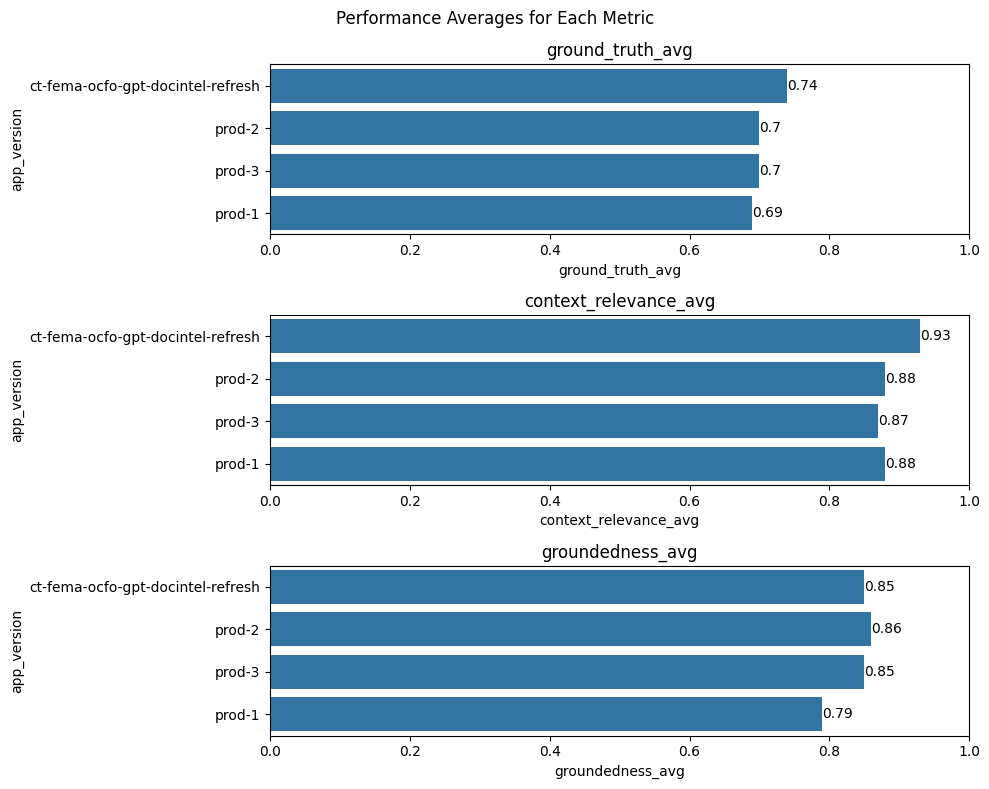

In [52]:
# Check overall results after averaging between replicates
fig, axs = plt.subplots(3, 1, figsize=(10, 2*len(results["app_version"].unique())))

results_agg = results.groupby("app_version", as_index=False).agg(
    ground_truth_avg=("Ground Truth", "mean"),
    context_relevance_avg=("Context Relevance", "mean"),
    groundedness_avg=("Groundedness", "mean"),
    record_ct=("app_version", "count")
).sort_values(by="ground_truth_avg", ascending=False)
results_agg = results_agg.round(2)

metrics = ["ground_truth_avg", "context_relevance_avg", "groundedness_avg"]
for i, metric in enumerate(metrics):
    sns.barplot(
        x=metric,
        y="app_version",
        data=results_agg,
        ax=axs[i],
        order=results_agg["app_version"],
        legend=False
    )
    axs[i].set_xlim(0, 1)
    axs[i].set_title(metric)

    for j in axs[i].containers:
        axs[i].bar_label(j,)

fig.suptitle("Performance Averages for Each Metric")
fig.tight_layout()

results_agg


## Local Evaluation: 
#### In which specific areas does each app version perform well / poorly?

Question Type Frequencies:


Type,Keyword,Number,Text
app_version,,,
ct-fema-ocfo-gpt-docintel-refresh,31,38,31
prod-1,31,38,31
prod-2,31,38,31
prod-3,31,38,31


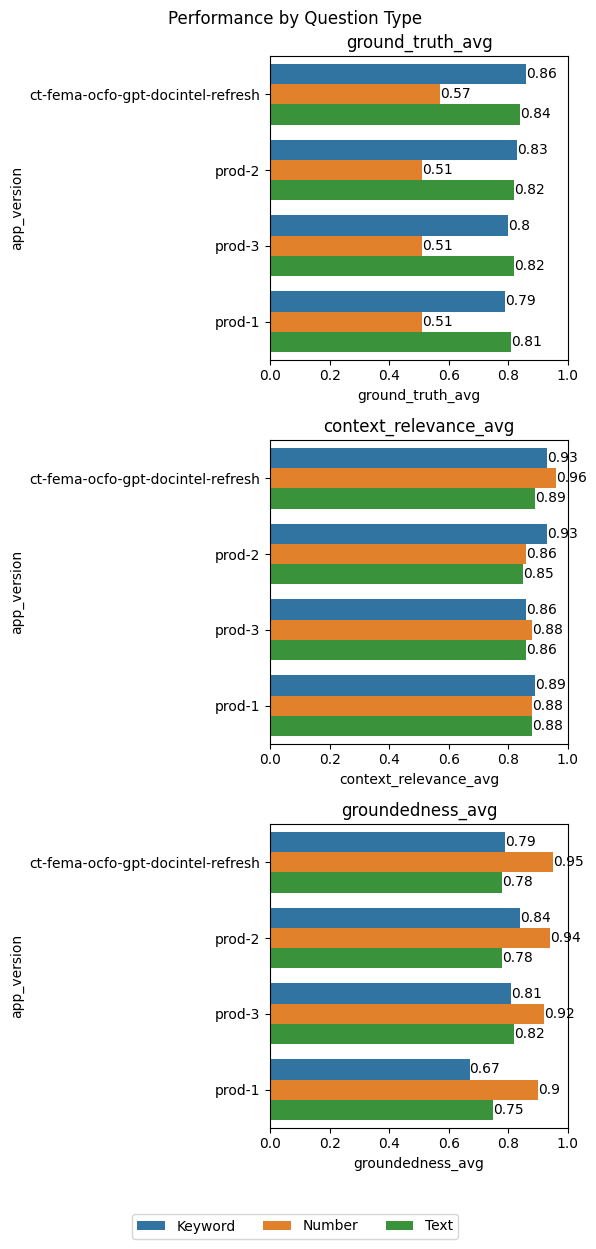

In [53]:
# Breakdown by question type
eval_results_by_type = results.groupby(["app_version", "Type"], as_index=False).agg(
    ground_truth_avg=("Ground Truth", "mean"),
    context_relevance_avg=("Context Relevance", "mean"),
    groundedness_avg=("Groundedness", "mean"),
    record_ct=("app_version", "count")
)
eval_results_by_type = eval_results_by_type.round(2)

fig, axs = plt.subplots(3, 1, figsize=(6, 3*len(results["app_version"].unique())))
metrics = ["ground_truth_avg", "context_relevance_avg", "groundedness_avg"]
for i, metric in enumerate(metrics):
    sns.barplot(
        x=metric,
        y="app_version",
        hue="Type",
        data=eval_results_by_type,
        order=results_agg["app_version"],
        ax=axs[i]
    )
    axs[i].set_xlim(0, 1)
    axs[i].set_title(metric)
    axs[i].get_legend().remove()

    for j in axs[i].containers:
        axs[i].bar_label(j,)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=len(eval_results_by_type["Type"].unique()), loc="lower center", bbox_to_anchor=(0.5, -0.05))
fig.suptitle("Performance by Question Type")
fig.tight_layout()

print("Question Type Frequencies:")
eval_results_by_type.pivot(values="record_ct", index=["app_version"], columns="Type")


Flag Frequencies:


Flags,Multi-page,"Multi-page, Table",None,Table
app_version,,,,
ct-fema-ocfo-gpt-lg-chunk-vectorKeyword,21,13,20,46
ct-fema-ocfo-gpt-med-chunk-vectorKeyword,25,14,22,39
ct-fema-ocfo-gpt-sm-chunk-vectorKeyword,25,14,22,39


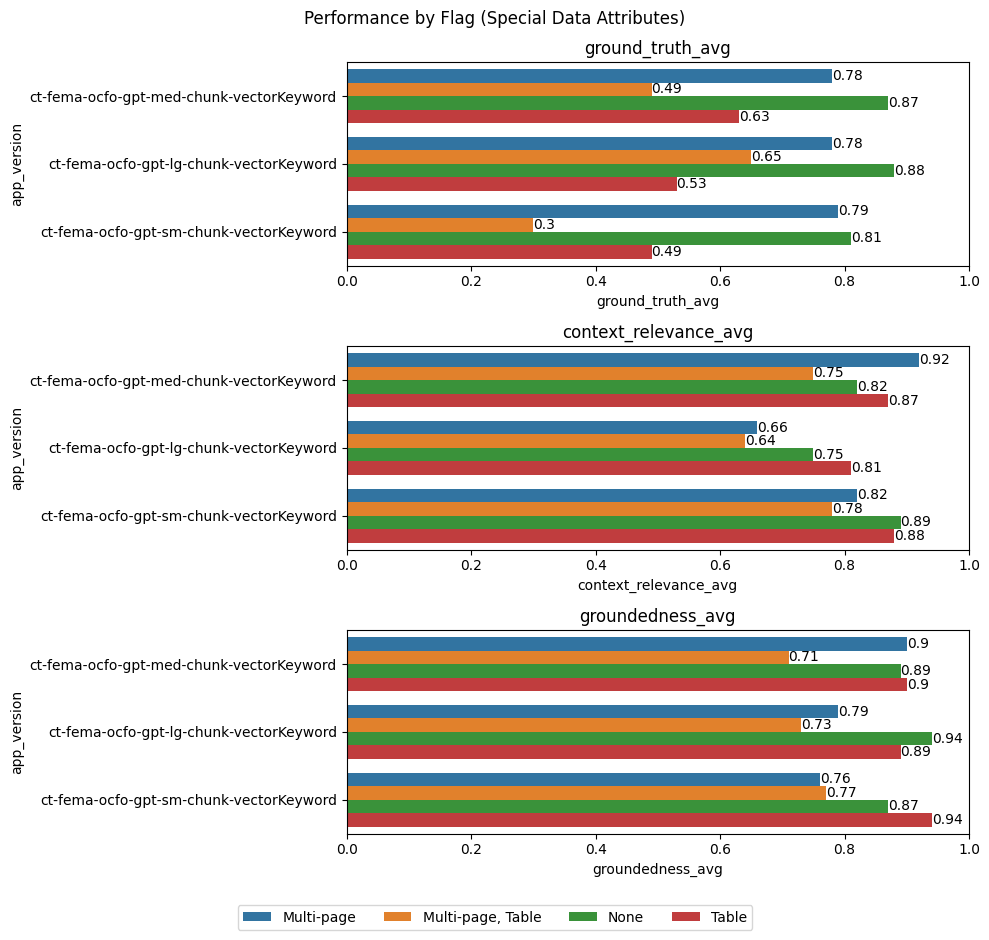

In [58]:
# Breakdown by flag type
results["Flags"].fillna("None", inplace=True)
results["Flags"] = results["Flags"].apply(lambda x: x.replace(", Negative", ""))

eval_results_by_flag = results.groupby(["app_version", "Flags"], as_index=False).agg(
        ground_truth_avg=("Ground Truth", "mean"),
        context_relevance_avg=("Context Relevance", "mean"),
        groundedness_avg=("Groundedness", "mean"),
        record_ct=("app_version", "count")
    )
eval_results_by_flag = eval_results_by_flag.round(2)

fig, axs = plt.subplots(3, 1, figsize=(10, 3*len(results["app_version"].unique())))
metrics = ["ground_truth_avg", "context_relevance_avg", "groundedness_avg"]
for i, metric in enumerate(metrics):
    sns.barplot(
        x=metric,
        y="app_version",
        hue="Flags",
        data=eval_results_by_flag,
        order=results_agg["app_version"],
        ax=axs[i]
    )
    axs[i].set_xlim(0, 1)
    axs[i].set_title(metric)
    axs[i].get_legend().remove()

    for j in axs[i].containers:
        axs[i].bar_label(j,)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=len(eval_results_by_flag["Flags"].unique()), bbox_to_anchor=(0.5, -.05))
fig.suptitle("Performance by Flag (Special Data Attributes)")
fig.tight_layout()

print("Flag Frequencies:")
eval_results_by_flag.pivot(values="record_ct", index=["app_version"], columns="Flags")


## Performance over time

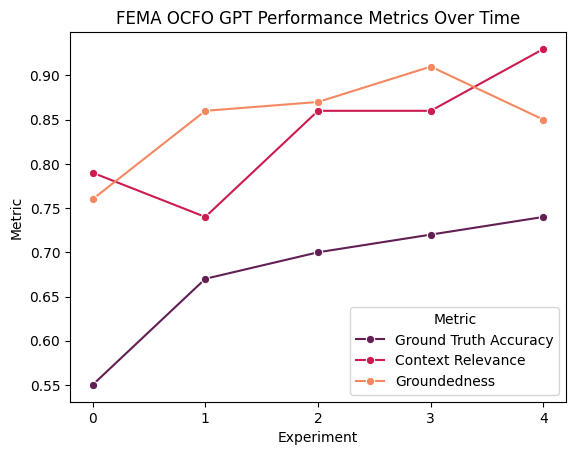

Pct Increase for Ground Truth Accuracy: 34.55
Pct Increase for Context Relevance: 17.72
Pct Increase for Groundedness: 11.84


In [53]:
import seaborn as sns
from  matplotlib.ticker import FuncFormatter
metrics_over_time = {
    "Experiment": ["0", "1", "2", "3", "4"],
    "Ground Truth Accuracy": [0.55, 0.67, 0.7, 0.72, 0.74],
    "Context Relevance": [0.79, 0.74, 0.86, 0.86, 0.93],
    "Groundedness": [0.76, 0.86, 0.87, 0.91, 0.85]
}

metrics_time_df = pd.DataFrame(metrics_over_time)
metrics_time_df = pd.melt(metrics_time_df, id_vars=["Experiment"], value_vars=["Ground Truth Accuracy", "Context Relevance", "Groundedness"])
sns.lineplot(x="Experiment", y="value", hue="variable", data=metrics_time_df, palette="rocket", marker="o")
plt.ylabel("Metric")
plt.legend(title="Metric")
plt.title("FEMA OCFO GPT Performance Metrics Over Time")

# ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.show()

for metric in ["Ground Truth Accuracy", "Context Relevance", "Groundedness"]:
    pct_increase = round(((metrics_over_time[metric][-1] - metrics_over_time[metric][0]) / metrics_over_time[metric][0]) * 100, 2)
    print(f"Pct Increase for {metric}: {pct_increase}")

In [48]:
metrics_time_df.dtypes

Experiment      int64
variable       object
value         float64
dtype: object

## Meta-Analysis:
#### How accurate is the Ground Truth evaluator? 

In [110]:
def error_type(pred, correctness):
    if correctness == 0:
        if pred == 1:
            return "FP"
        else:
            return "FN"
    else:
        if pred == 1:
            return "TP"
        else:
            return "TN"


manual_eval = pd.read_excel("trulens_eval_results_manual_eval.xlsx")
manual_eval.dropna(subset="Ground Truth Eval Correct", inplace=True)
manual_eval = manual_eval[manual_eval["app_id"]=="ct-nondocintel-fema-ocfo-gpt-vectorSimpleHybrid"]
print("App version:", app_version)

manual_eval["Ground Truth Class"] = manual_eval["Ground Truth"].apply(lambda x: round(x, 0))
manual_eval["error_type"] = manual_eval.apply(lambda x: error_type(x["Ground Truth Class"], x["Ground Truth Eval Correct"]), axis=1)

for qtype in ["Number", "Keyword", "Text"]:
    type_eval = manual_eval[manual_eval["Type"]==qtype]
    type_eval_errors = type_eval.groupby("error_type").agg(ct=("app_id", "count"))
    for error_type in ["TP", "FP", "FN", "TN"]:
        try:
            type_eval_errors.loc[error_type, "ct"]
        except:
            type_eval_errors.loc[error_type] = 0
    
    errors = {}
    errors["TPR"] = type_eval_errors.loc["TP", "ct"] / (type_eval_errors.loc["TP", "ct"] + type_eval_errors.loc["FN", "ct"])
    errors["FPR"] = type_eval_errors.loc["FP", "ct"] / (type_eval_errors.loc["FP", "ct"] + type_eval_errors.loc["TN", "ct"])
    errors["TNR"] = type_eval_errors.loc["TN", "ct"] / (type_eval_errors.loc["FP", "ct"] + type_eval_errors.loc["TN", "ct"])
    errors["FNR"] = type_eval_errors.loc["FN", "ct"] / (type_eval_errors.loc["TP", "ct"] + type_eval_errors.loc["FN", "ct"])
    
    print(f"{qtype} Question Type Results:")
    for error in ["TPR", "FNR", "TNR", "FPR"]:
        print(f"{error}: {errors[error]}")
    print("\n")



App version: ct-fema-ocfo-gpt_fulltest1
Number Question Type Results:
TPR: 0.9090909090909091
FNR: 0.09090909090909091
TNR: 1.0
FPR: 0.0


Keyword Question Type Results:
TPR: 1.0
FNR: 0.0
TNR: 1.0
FPR: 0.0


Text Question Type Results:
TPR: 0.9583333333333334
FNR: 0.041666666666666664
TNR: 1.0
FPR: 0.0




In [5]:
from dataclasses import dataclass
from typing import Optional, Dict, List

@dataclass
class Document(object):
    """A data class for storing documents

    Attributes:
        content (str): The content of the document.
        id (Optional[str]): The id of the document.
        title (Optional[str]): The title of the document.
        filepath (Optional[str]): The filepath of the document.
        url (Optional[str]): The url of the document.
        metadata (Optional[Dict]): The metadata of the document.    
    """

    content: str
    id: Optional[str] = None
    doc_type: Optional[str] = None
    title: Optional[str] = None
    filepath: Optional[str] = None
    url: Optional[str] = None
    metadata: Optional[Dict] = None
    contentVector: Optional[List[float]] = None

    def to_dict(self):
        """
        Returns the Dataset object in JSON compatible encoding
        """
        return {
            "content": self.content,
            "id": self.id,
            "doc_type": self.doc_type,
            "title": self.title,
            "filepath": self.filepath,
            "url": self.url,
            "metadata": self.metadata,
            "contentVector": self.contentVector
        }


test = Document(
    content="hi",
    id=1,
    doc_type="test",
    title="title",
    filepath="filepath/doc.txt",
    url="www.url.com",
    metadata={"item1": "three", "item2": 5},
    contentVector=[1, 3, 5]
)

test.to_dict()

{'content': 'hi',
 'id': 1,
 'doc_type': 'test',
 'title': 'title',
 'filepath': 'filepath/doc.txt',
 'url': 'www.url.com',
 'metadata': {'item1': 'three', 'item2': 5},
 'contentVector': [1, 3, 5]}

In [114]:
manual_eval = pd.read_excel("trulens_eval_results_manual_eval.xlsx")
manual_eval.dropna(subset="Ground Truth Eval Correct", inplace=True)
manual_eval = manual_eval[manual_eval["app_id"]=="ct-fema-ocfo-gpt_fulltest1"]
print("App version:", "ct-fema-ocfo-gpt_fulltest1")

manual_eval["Ground Truth Class"] = manual_eval["Ground Truth"].apply(lambda x: round(x, 0))
print(manual_eval.head())
manual_eval["error_type"] = manual_eval.apply(lambda x: error_type(x["Ground Truth Class"], x["Ground Truth Eval Correct"]), axis=1)

for qtype in ["Number", "Keyword", "Text"]:
    type_eval = manual_eval[manual_eval["Type"]==qtype]
    type_eval_errors = type_eval.groupby("error_type").agg(ct=("app_id", "count"))
    for error_type in ["TP", "FP", "FN", "TN"]:
        try:
            type_eval_errors.loc[error_type, "ct"]
        except:
            type_eval_errors.loc[error_type] = 0
    
    errors = {}
    errors["TPR"] = type_eval_errors.loc["TP", "ct"] / (type_eval_errors.loc["TP", "ct"] + type_eval_errors.loc["FN", "ct"])
    errors["FPR"] = type_eval_errors.loc["FP", "ct"] / (type_eval_errors.loc["FP", "ct"] + type_eval_errors.loc["TN", "ct"])
    errors["TNR"] = type_eval_errors.loc["TN", "ct"] / (type_eval_errors.loc["FP", "ct"] + type_eval_errors.loc["TN", "ct"])
    errors["FNR"] = type_eval_errors.loc["FN", "ct"] / (type_eval_errors.loc["TP", "ct"] + type_eval_errors.loc["FN", "ct"])
    
    print(f"{qtype} Question Type Results:")
    for error in ["TPR", "FNR", "TNR", "FPR"]:
        print(f"{error}: {errors[error]}")
    print("\n")

App version: ct-fema-ocfo-gpt_fulltest1
                       app_id  \
0  ct-fema-ocfo-gpt_fulltest1   
1  ct-fema-ocfo-gpt_fulltest1   
2  ct-fema-ocfo-gpt_fulltest1   
3  ct-fema-ocfo-gpt_fulltest1   
4  ct-fema-ocfo-gpt_fulltest1   

                                              prompt  \
0  What was the increase in total enacted budget ...   
1  For FEMA Operations and Support, what is the F...   
2  How many FTEs were enacted/requested across al...   
3  What was the Civilian Pay Raise Total for FEMA...   
4  Which program annualization within FEMA Operat...   

                                              output  \
0  "The increase in total enacted budget for FEMA...   
1  "The FY 2024 President's Budget amount for the...   
2  "In FY 2023, the number of FTEs enacted/reques...   
3  "The Civilian Pay Raise Total for FEMA Operati...   
4  "The program annualization within FEMA Operati...   

                               gold_answer     Type              Flags  \
0            

TypeError: 'str' object is not callable

#### How closely do the outputs align with the deployed app versions in terms of citations? 

In [8]:
class RAG_Pipeline_Test:
    def retrieve(self, query: str) -> list:
        self.response = aoai_answer(query)
        citation_json = ast.literal_eval(self.response["choices"][0]["messages"][0]["content"].replace("null", '""'))["citations"]
        citations = [citation["content"] for citation in citation_json]
        return citations

    def generate_completion(self, query: str, context_str: list) -> str:
        return self.response["choices"][0]["messages"][1]["content"]

    def query(self, query: str) -> str:
        context_str = self.retrieve(query)
        completion = self.generate_completion(query, context_str)
        return completion

pipeline_test = RAG_Pipeline_Test()

In [16]:
smoke_test = pd.read_excel("smoke_test.xlsx")

for version in ["ct-fema-ocfo-gpt", "ct-tst1-fema-ocfo-gpt", "ct-tst2-fema-ocfo-gpt"]:
    settings.VERSION_ID = version
    settings.get_version_configs()

    # Overwrite system settings with experiment-specific configs
    settings.AZURE_OPENAI_MODEL = "dep-chatgpt"
    os.environ["AZURE_OPENAI_API_KEY"] = settings.AZURE_OPENAI_KEY

    for question in tqdm(smoke_test["Question"], desc=f"smoke testing prompts for version {version}"):
        citations = pipeline_test.retrieve(question)
        answer = pipeline_test.generate_completion(question, citations)
        smoke_test.loc[smoke_test["Question"]==question, f"{version} (Exp) Sources"] = f"""Answer: {answer}
        
        Citations: {citations}"""
    
    #smoke_test[f"{version} (Exp) n_citations"] = smoke_test[f"{version} (Exp) Sources"].apply(lambda x: len(ast.literal_eval(x)))

smoke testing prompts for version ct-fema-ocfo-gpt:   0%|          | 0/5 [00:00<?, ?it/s]

smoke testing prompts for version ct-fema-ocfo-gpt: 100%|██████████| 5/5 [00:37<00:00,  7.56s/it]
smoke testing prompts for version ct-tst1-fema-ocfo-gpt:  40%|████      | 2/5 [00:14<00:22,  7.58s/it]

Request failed likely due to rate limit. Waiting 1 min and retrying...


smoke testing prompts for version ct-tst1-fema-ocfo-gpt: 100%|██████████| 5/5 [01:34<00:00, 18.80s/it]
smoke testing prompts for version ct-tst2-fema-ocfo-gpt:  80%|████████  | 4/5 [00:32<00:08,  8.20s/it]

Request failed likely due to rate limit. Waiting 1 min and retrying...


smoke testing prompts for version ct-tst2-fema-ocfo-gpt: 100%|██████████| 5/5 [01:38<00:00, 19.65s/it]


In [17]:
smoke_test.to_excel("smoke_test.xlsx", index=False)

## Experiment System 2: Without Trulens
#### Deprecated, moving forward with System 1

In [34]:
eval_set = pd.read_excel("FEMA_eval_set.xlsx")

tqdm.pandas(desc="generating responses")
eval_set["prompt"] = eval_set.apply(lambda x: create_prompt(x["Question"], x["Type"]), axis=1)
eval_set["response"] = eval_set["prompt"].progress_apply(lambda x: aoai_answer(x))
eval_set["gen_text"] = eval_set["response"].apply(lambda x: x["choices"][0]["messages"][1]["content"])
eval_set["cost_gpt_4_32k"] = eval_set["response"].apply(lambda x: get_cost(x, "gpt-4-32k"))
eval_set["cost_gpt_3.5_16k"] = eval_set["response"].apply(lambda x: get_cost(x, "gpt-3.5-turbo-16k"))

tqdm.pandas(desc="evaluating")
eval_set["score"] = eval_set.progress_apply(lambda x: check_answer(x["Answer"], x["gen_text"], x["Type"]), axis=1)

generating responses:   0%|          | 0/12 [00:00<?, ?it/s]

generating responses:  67%|██████▋   | 8/12 [00:43<00:24,  6.21s/it]

Request failed likely due to rate limit. Waiting 1 min and retrying...


evaluating: 100%|██████████| 12/12 [00:01<00:00, 11.69it/s]


In [42]:
citation_json = ast.literal_eval(res["choices"][0]["messages"][0]["content"].replace("null", '""'))["citations"]
citations = [citation["content"] for citation in citation_json]
citations

["0 Land and Structures\t$117,210\t$75,105\t$35,000\t($40,105)\nTotal - Non Pay Budget Object Class\t$209,985\t$207,730\t$119,137\t($88,593)\nProcurement, Construction, and Improvements\nCapital Investment Exhibits\nCapital Investments\n(Dollars in Thousands)\n\tAcquisition Level\tIT/ Non-IT\tMAOL\tFY 2022 Enacted\tFY 2023 Enacted\tFY 2024 President's Budget\t\n \n024_000007001 - Integrated Public Alert and Warning System (IPAWS)\tLevel 2\tIT\tYes\t$10,785\t$12,902\t$11,900\t\n024_000007592 - National Warning System (NAWAS)\tLevel 2\tIT\tNo\t$3,000\t$3,000\t-\t\n024_000007521 - National Fire Incident Reporting System\tLevel 3\tIT\tNo\t-\t-\t$10,000\t\n024_000007547 - Grants Management Modernization\tLevel 2\tIT\tYes\t$45,847\t$51,054\t$14,500\t\n024_000007103 - Financial Systems Modernization\tLevel 2\tIT\tNo\t$8,332\t$12,025\t$8,520\t\n024_000007002 - Enterprise Data & Analytics Modernization\tLevel 3\tIT\tNo\t$6,038\t$33,544\t$29,717\t\n024_000007143 - Identity Access Control Systems

In [121]:
mini_eval_set["error"] = mini_eval_set["response"].apply(lambda x: True if "error" in x.keys() else False)
mini_eval_set_filtered = mini_eval_set[mini_eval_set["error"] == False]
mini_eval_set_filtered["gen_text"] = mini_eval_set_filtered["response"].apply(lambda x: x["choices"][0]["messages"][1]["content"])
mini_eval_set_filtered["cost_gpt_4_32k"] = mini_eval_set_filtered["response"].apply(lambda x: get_cost(x, "gpt-4-32k"))
mini_eval_set_filtered["cost_gpt_3.5_16k"] = mini_eval_set_filtered["response"].apply(lambda x: get_cost(x, "gpt-3.5-turbo-16k"))

tqdm.pandas(desc="evaluating")
mini_eval_set_filtered["score"] = mini_eval_set_filtered.progress_apply(lambda x: check_answer(x["Answer"], x["gen_text"], x["Type"]), axis=1)

evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

evaluating: 100%|██████████| 11/11 [00:00<00:00, 18.81it/s]


In [117]:
mini_eval_set_filtered.to_csv("mini_eval_results.csv", encoding="utf-8-sig")

In [122]:
mini_eval_set_filtered["Prompt Tokens"] = mini_eval_set_filtered["response"].apply(lambda x: x["usage"]["prompt_tokens"])
mini_eval_set_filtered["Response Tokens"] = mini_eval_set_filtered["response"].apply(lambda x: x["usage"]["completion_tokens"])

Average Prompt Tokens: 7885.090909090909
Average Completion Tokens: 136.1818181818182
Estimated Azure costs for GPT-4 (32k context) per experiment (in dollars): 48.94472727272728
Estimated Azure costs for GPT-3.5 Turbo (16k context) per experiment (in dollars): 2.42


In [123]:
print("Average Prompt Tokens:", mini_eval_set_filtered["Prompt Tokens"].mean())
print("Average Completion Tokens:", mini_eval_set_filtered["Response Tokens"].mean())

print("Estimated Azure costs for GPT-4 (32k context) per experiment (in dollars):", mini_eval_set_filtered["cost_gpt_4_32k"].sum() * (100 / len(mini_eval_set_filtered)))
print("Estimated Azure costs for GPT-3.5 Turbo (16k context) per experiment (in dollars):", mini_eval_set_filtered["cost_gpt_3.5_16k"].sum() * (100 / len(mini_eval_set_filtered)))

Average Prompt Tokens: 7885.090909090909
Average Completion Tokens: 136.1818181818182
Estimated Azure costs for GPT-4 (32k context) per experiment (in dollars): 48.94472727272728
Estimated Azure costs for GPT-3.5 Turbo (16k context) per experiment (in dollars): 2.42


In [30]:
# CAUTION: THIS DELETES ALL PAST EXPERIMENT RESULTS FROM TRULENS DB. ONLY RUN THIS CELL IF YOU WANT TO CLEAR PAST TRULENS RESULTS
tru.reset_database()